# SEAROSE ICE INCURSION INCIDENT

In [1]:
import netCDF4 as nc
import numpy as np
import xarray as xr

# CONSTANTS

In [2]:
from icedef.constants import *

# SEAROSE

In [3]:
searose_latitude = 46.78851
searose_longitude = -48.01405

# ICEBERG

In [4]:
from icedef.iceberg import quickstart, dx_to_dlon, dy_to_dlat

In [5]:
# At 0145 on March 29, 2017, berg 011 was 4.2 NM away from SeaRose at a bearing of 346 deg T
iceberg_time = np.datetime64('2017-03-29T01:45')
iceberg_latitude = 46.85639904
iceberg_longitude = -48.03872578
iceberg = quickstart(iceberg_time, (iceberg_latitude, iceberg_longitude))

In [28]:
start_time = iceberg_time
end_time = np.datetime64(iceberg_time + np.timedelta64(1, 'D'))
start_latitude = iceberg_latitude
start_longitude = iceberg_longitude

# METOCEAN

In [7]:
from icedef import metocean

In [19]:
ocean = metocean.ECMWFOcean((start_time, end_time))
atm = metocean.NARRAtmosphere((start_time, end_time))

# DRIFT

In [20]:
from icedef import drift

In [27]:
dt_hours = 0.1
dt_seconds = dt_hours*3600
dt = np.timedelta64(int(dt_seconds), 's')
run_length = np.timedelta64(end_time - start_time, 's')
nt = run_length / dt

In [23]:
iceberg = quickstart(start_time, (start_latitude, start_longitude))

iceberg_constants = {
    'sail_area': iceberg.geometry.sail_area,
    'keel_area': iceberg.geometry.keel_area,
    'top_area': iceberg.geometry.waterline_length**2,
    'bottom_area': 0,
    'mass': iceberg.geometry.mass,
    'latitude': iceberg.latitude
}

point = (iceberg.time, iceberg.latitude, iceberg.longitude)

current_velocity = (metocean.interpolate(point, ocean.eastward_current_velocities),
                    metocean.interpolate(point, ocean.northward_current_velocities))

wind_velocity = (metocean.interpolate(point, atm.eastward_wind_velocities),
                 metocean.interpolate(point, atm.northward_wind_velocities))

for t in range(int(nt)):
    
    ax, ay = drift.newtonian_drift((iceberg.eastward_velocity, iceberg.northward_velocity), 
                             current_velocity, wind_velocity, 
                             iceberg_constants)
    
    iceberg.time += dt
    iceberg.eastward_velocity += ax * dt_seconds
    iceberg.northward_velocity += ay * dt_seconds
    iceberg.latitude += dy_to_dlat(iceberg.northward_velocity * dt_seconds)
    iceberg.longitude += dx_to_dlon(iceberg.eastward_velocity * dt_seconds, iceberg.latitude)
    
    point = (iceberg.time, iceberg.latitude, iceberg.longitude)
    
    current_velocity = (metocean.interpolate(point, ocean.eastward_current_velocities),
                        metocean.interpolate(point, ocean.northward_current_velocities))

    wind_velocity = (metocean.interpolate(point, atm.eastward_wind_velocities),
                     metocean.interpolate(point, atm.northward_wind_velocities))
    
    iceberg_constants['latitude'] = iceberg.latitude
    iceberg.update_history()

# PLOT

In [24]:
import matplotlib.pyplot as plt
%matplotlib inline

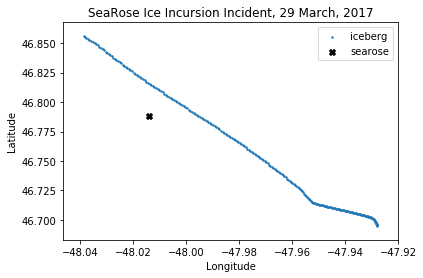

In [25]:
plt.scatter(iceberg.history['longitude'], iceberg.history['latitude'], 
            s=2, label='iceberg')
plt.scatter(searose_longitude, searose_latitude, marker='X', c='black', label='searose')
plt.legend()
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('SeaRose Ice Incursion Incident, 29 March, 2017')
plt.show()